In [1]:
# Create a folder for open-images-v5
!mkdir -p open-images-v5
%cd open-images-v5

C:\Users\vmurc\Documents\open-images-v5


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file open-images-v5 already exists.
Error occurred while processing: open-images-v5.


In [28]:
#Environment setup for image classification
from pycocotools.coco import COCO
from tqdm import tqdm_notebook
import urllib.request
import os
import cv2
import wget
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)

from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
#Keras packages
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [4]:
#Download openimage database from Google
# Training bounding boxes (1.11G)
trbbs = wget.download('https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv')

# Validating bounding boxes (23.94M)
vbbs = wget.download('https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv')
    
# Testing bounding boxes (73.89M)
tebbs = wget.download('https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv')

# Class names of images (11.73K)
cNames = wget.download('https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv')

  0% [                                                                    ]    7110656 / 1194033454

  1% [                                                                    ]   13975552 / 1194033454

  1% [.                                                                   ]   22323200 / 1194033454

  2% [.                                                                   ]   30244864 / 1194033454

  3% [..                                                                  ]   37715968 / 1194033454

  3% [..                                                                  ]   44589056 / 1194033454

  4% [..                                                                  ]   52371456 / 1194033454

  4% [...                                                                 ]   59293696 / 1194033454

  5% [...                                                                 ]   66560000 / 1194033454

  6% [....                                                                ]   73506816 / 1194033454

  6% [....                                                                ]   80379904 / 1194033454

  7% [.....                                                               ]   88489984 / 1194033454

  8% [.....                                                               ]   95592448 / 1194033454

  8% [.....                                                               ]  103227392 / 1194033454

  9% [......                                                              ]  110936064 / 1194033454

  9% [......                                                              ]  118956032 / 1194033454

 10% [.......                                                             ]  126910464 / 1194033454

 11% [.......                                                             ]  135192576 / 1194033454

 11% [........                                                            ]  142860288 / 1194033454

 12% [........                                                            ]  150175744 / 1194033454

 13% [........                                                            ]  156942336 / 1194033454

 13% [.........                                                           ]  165363712 / 1194033454

 14% [.........                                                           ]  173236224 / 1194033454

 15% [..........                                                          ]  180477952 / 1194033454

 15% [..........                                                          ]  188776448 / 1194033454

 16% [...........                                                         ]  195944448 / 1194033454

 17% [...........                                                         ]  203415552 / 1194033454

 17% [...........                                                         ]  210509824 / 1194033454

 18% [............                                                        ]  218669056 / 1194033454

 18% [............                                                        ]  226304000 / 1194033454

 19% [.............                                                       ]  234078208 / 1194033454

 20% [.............                                                       ]  241360896 / 1194033454

 20% [..............                                                      ]  248381440 / 1194033454

 21% [..............                                                      ]  256204800 / 1194033454

 21% [..............                                                      ]  258785280 / 1194033454

100% [..............................................................................] 12011 / 12011

In [32]:
# Extracted data from Google Open Images using code from -> -https://github.com/pythonlessons/OIDv4_ToolKit

In [33]:
#Loading function
labels = ['Cat', 'Bear']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [35]:
#Load the data
path2files = r'C:\Users\vmurc\Documents\ml_OIDv4\OIDv4_ToolKit\OID\Dataset'
train = get_data(path2files + '\\train')
val = get_data(path2files + '\\test')

'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable


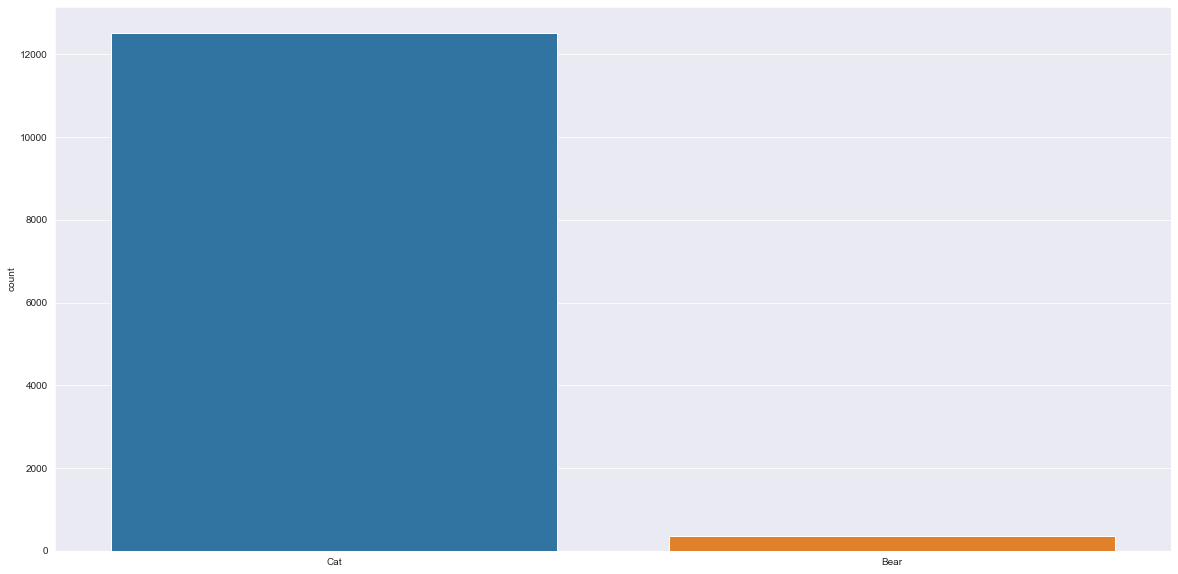

In [37]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Cat")
    else:
        l.append("Bear")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'Cat')

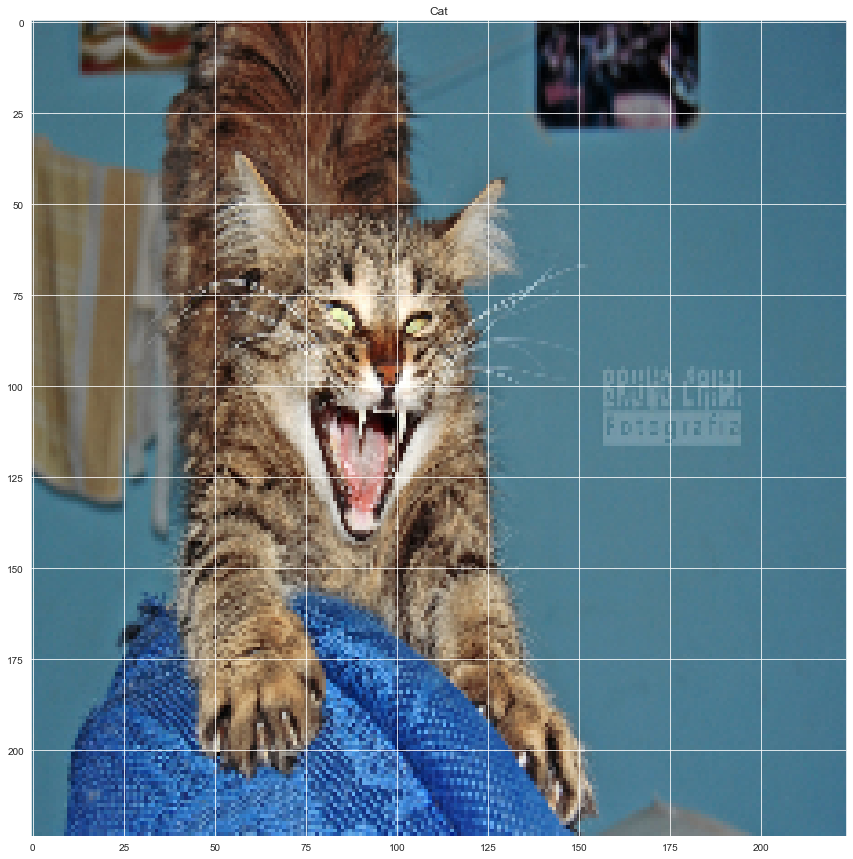

In [44]:
#visualize a random image from cat class
plt.figure(figsize = (15,15))
plt.imshow(train[2][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'Bear')

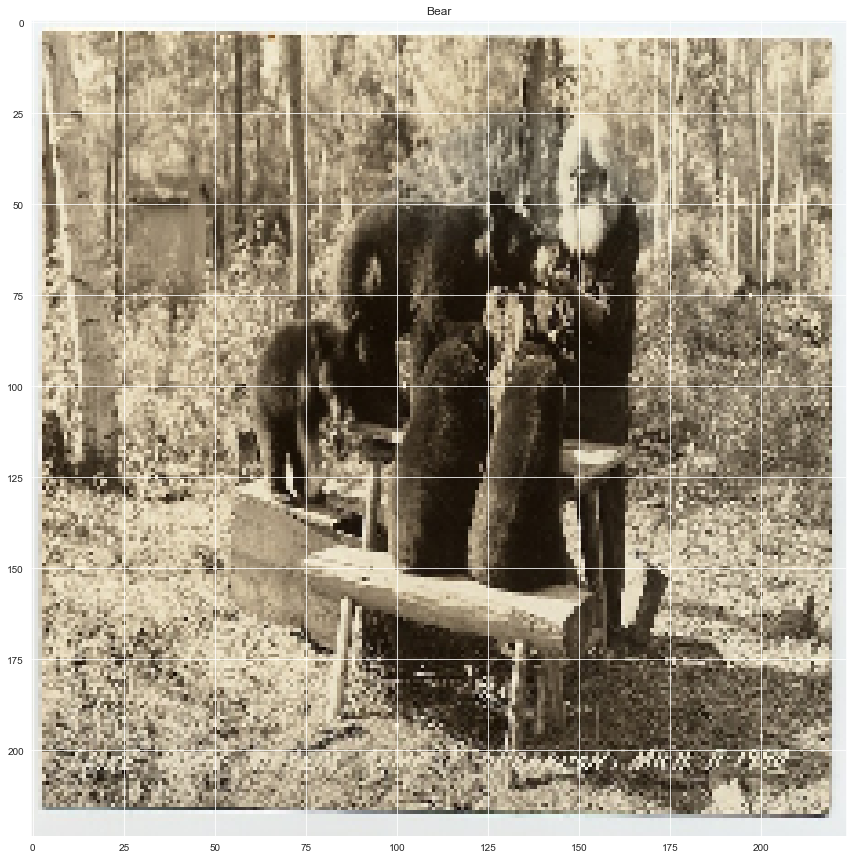

In [45]:
#visualize a random image from bear class
plt.figure(figsize = (15,15))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [46]:
#Data Preprocessing 
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [47]:
# Data Augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [48]:
#Model definition
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)      

In [57]:
#Compile model using Adam as optimizer
opt = Adam(lr=0.000001 )
# Callback will stop  training when there is no improvement in the loss for three consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [ ]:
#Train model with 500 epochs
history = model.fit(x_train,y_train,epochs = 50 , validation_data = (x_val, y_val), callbacks=[callback])

Train on 12869 samples, validate on 1043 samples
Epoch 1/50
12869/12869 [==============================] - 217s 17ms/step - loss: 0.3407 - accuracy: 1.0000 - val_loss: 0.3717 - val_accuracy: 1.0000
Epoch 2/50
12869/12869 [==============================] - 216s 17ms/step - loss: 0.3407 - accuracy: 1.0000 - val_loss: 0.3717 - val_accuracy: 1.0000
Epoch 3/50
12869/12869 [==============================] - 218s 17ms/step - loss: 0.3407 - accuracy: 1.0000 - val_loss: 0.3717 - val_accuracy: 1.0000
Epoch 4/50
12869/12869 [==============================] - 213s 17ms/step - loss: 0.3407 - accuracy: 1.0000 - val_loss: 0.3717 - val_accuracy: 1.0000
Epoch 5/50
12869/12869 [==============================] - 214s 17ms/step - loss: 0.3407 - accuracy: 1.0000 - val_loss: 0.3717 - val_accuracy: 1.0000
Epoch 6/50
 1664/12869 [==>...........................] - ETA: 3:03 - loss: 0.3439 - accuracy: 1.0000

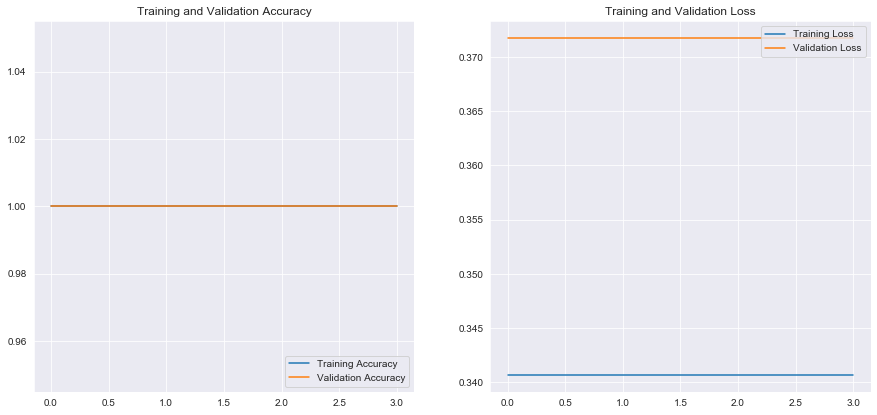

In [56]:
#Evaluating the result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(4)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()